# ORIE 5355/INFO 5370 HW 1: Survey Weighting

 - Name: Martin Sun
 - Net-id: ms2923
 - Date: 2021-09-18
 - Late days used for this assignment: 1
 - Total late days used (counting this assignment): 1
 - People with whom you discussed this assignment: Ethan Glaser
 
 https://github.com/martinsun0/People-Data-Systems/blob/main/HW1/HW1_assignment.ipynb
 I don't know how to make a nice PDF yet. Sorry!

After you finish the homework, please complete the following (short, anonymous) post-homework survey: https://forms.gle/spVRAkxcqcDuxkuY6

We have marked questions in <font color='blue'> blue </font>. Please put answers in black (do not change colors). You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2021/assignments/). 

# Conceptual component

### 1) Reading

<font color='blue'> Please read Sections 3 and 4 (pages 6-13) here: https://www.nber.org/system/files/working_papers/w20830/w20830.pdf, and answer the following questions.

<font color='blue'> Please summarize the sections in no more than two sentences. 

Section 3 discusses Ebay's seller metrics and asserts that the "percent positive" and "feedback score" measures are inadequate due to susceptibility to biases and highly skewed, non-differentiable data.
The author suggests a new metric, EPP, to capture "unobserved" seller quality and to corroborate this, the purchasing behaviour of about a million buyers were sampled and analyzed.

<font color='blue'> Do you think it's a problem that most ratings are positive? If so, why? Answer in no more than three sentences. Please incorporate concepts discussed in class in your answer. 

It becomes a problem when the fraction of highly positive ratings becomes very close to 100%, primarily because it detracts from the whole purpose of a seller rating - to differentiate good and bad sellers.
It can also be a sign of measurement error caused by differential non-response because dissatisfied customers may be less inclined to comment at all on their experience, and simply select another seller the next time. Explicit and implicit pressure can also be reflected by highly skewed rating distributions.

### 2) Personal reflection

<font color='blue'> Think back to a time that you trained a model on data from people or gathered opinions via a survey (an informal one is fine). If you have not done that before, you may answer these questions about an article in the news that reported on public opinions or a model that you think might be in deployment at a company or organization with which you interact (for example, Amazon, google maps, etc)

<font color='blue'> Briefly summarize the scenario in no more than two sentences. 

During undergrad, I surveyed fellow students about how they felt about their screen time and increased electronics usage especially during the pandemic.

<font color='blue'> What was the construct that you cared about/wanted to measure? What was the measurement (numerical data)? In what ways did the measurement not match the construct you cared about? Answer in no more than 4 sentences.  

I wanted to determine what a college student would do about their unhealthy screen time and lack of physical activity (when applicable).
The numerical data was relative percentages of different response groups.
I was looking to answer whether college students would be willing to purchase a product to help their situation. Unfortunately, I did not receive much useful insight at all because the large majority of responses answered "not concerned" about their habits.


<font color='blue'> What selection biases/differential non-response issues occurred and how did it affect your measurement? (If your answer is "None," explain exactly why you believe the assumptions discussed in class were met). Answer in no more than 3 sentences. 

There is absolutely some social pressure, even though the survey was anonymous, to appear more sociable and less "nerdy" in a sense, which creates a bias in the measurement.
On the other hand, those that are more busy with screen usage are more likely to see the survey and respond to it, creating a differential non-response issue.
My data however, pointed towards to first effect.

<font color='blue'> Given what we have learned in class so far, what would you do differently if faced with the same scenario again? Answer in no more than 3 sentences. 

I would ask for more quantitative information because it requires less judgement and thinking from the person being surveyed - to me, it appeared that my biggest problem was that the questions were too qualitative.
To combat the selection biases I mentioned, I could survey different programs as separate groups, and conduct constant stratification sampling of the two main groups of students until I achieved parity.
With that being said, it is difficult to know the actual population distribution of these two student groups and so I would need to perform a detailed estimate of the population and quantify the uncertainty.

# Programming component

<font color='blue'> In this part of the homework, we provide you with data from a poll in Florida before the 2016 Presidential election in the United States. We also provide you with (one pollster's) estimates of who will vote in the 2016 election, made before the election. You will use this data and apply the weighting techniques covered in class.

## Preliminaries to load packages and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dfpoll = pd.read_csv('polling_data_hw1.csv') # raw polling data
dfpoll.head()

,candidate,age,gender,party,race,education
0,Someone else,30-44,Male,Independent,White,College
1,Hillary Clinton,45-64,Male,Republican,Hispanic,College
2,Hillary Clinton,30-44,Male,Independent,Hispanic,College
3,Hillary Clinton,65+,Female,Democrat,White,College
4,Donald Trump,65+,Female,Republican,White,High School


In [3]:
dfdemographic = pd.read_csv('florida_proportions_hw1.csv') # proportions of population
dfdemographic.head()

,Electoral_Proportion,Demographic_Type_1,Demographic_Type_2,Demographic_1,Demographic_2
0,0.387927,party,NaN,Democrat,NaN
1,0.398788,party,NaN,Republican,NaN
2,0.213285,party,NaN,Independent,NaN
3,0.445928,gender,NaN,Male,NaN
4,0.554072,gender,NaN,Female,NaN


dfdemographic contains estimates of likely voters in Florida in 2016. When Demographic_Type_2 is NaN, the row refers to just the marginal population percentage of the group in Demographic_1 of type Demographic_Type_1. When it is not NaN, the row has the joint distribution of the corresponding demographic groups.

## Part A: Raw visualization

<font color='blue'> Here, we'll visualize whether the respondents in the poll match the likely voter estimates. Create a scatter-plot where each point represents one Demographic group (for example, party-Independent), where the X axis is the Electoral_Proportion in dfdemographic, and the Y axis is the proportion in dfpoll. 

In [4]:
total = len(dfpoll)

In [5]:
dfdemographic['Poll_Proportion'] = ""

for index, row in dfdemographic.iterrows():
    type_list = dfdemographic[['Demographic_Type_1', 'Demographic_Type_2']].iloc[index].values.tolist()
    group_list = dfdemographic[['Demographic_1', 'Demographic_2']].iloc[index].values.tolist()
    if pd.isna(type_list[1]):
        df_group = dfpoll.groupby(type_list[0])[type_list[0]].count().reset_index(name ='count')
        n = df_group[(df_group[type_list[0]] == group_list[0])]['count'].iloc[0]
        percentage = n/total
        dfdemographic.Poll_Proportion[index] = percentage
    else:
        df_group = dfpoll.groupby(type_list)[type_list[1]].count().reset_index(name ='count')
        n = df_group[(df_group[type_list[0]] == group_list[0]) &
                     (df_group[type_list[1]] == group_list[1])]['count'].iloc[0]
        percentage = n/total
        dfdemographic.Poll_Proportion[index] = percentage

dfdemographic = dfdemographic.reindex(columns = ['Electoral_Proportion', 'Poll_Proportion',
                                 'Demographic_Type_1', 'Demographic_Type_2',
                                 'Demographic_1', 'Demographic_2'])
dfdemographic

<ipython-input-5-4c1a0b15f035>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfdemographic.Poll_Proportion[index] = percentage
<ipython-input-5-4c1a0b15f035>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfdemographic.Poll_Proportion[index] = percentage


,Electoral_Proportion,Poll_Proportion,Demographic_Type_1,Demographic_Type_2,Demographic_1,Demographic_2
0,0.387927,0.358708,party,NaN,Democrat,NaN
1,0.398788,0.272203,party,NaN,Republican,NaN
2,0.213285,0.348328,party,NaN,Independent,NaN
3,0.445928,0.491349,gender,NaN,Male,NaN
4,0.554072,0.508651,gender,NaN,Female,NaN
...,...,...,...,...,...,...
112,0.034216,0.068051,race,education,Hispanic,Some College
113,0.027588,0.084198,race,education,Hispanic,College
114,0.010929,0.00692,race,education,Other,High School
115,0.010570,0.014994,race,education,Other,Some College


C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


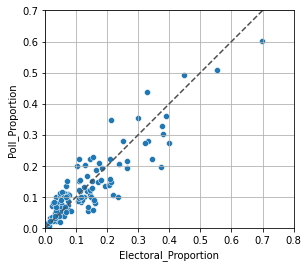

In [6]:
plt1 = sns.scatterplot(dfdemographic.Electoral_Proportion,dfdemographic.Poll_Proportion)
plt1.grid(True)
plt1.set(xlim = [0, 0.8])
plt1.set(ylim = [0, 0.7])
plt1.set_aspect('equal')
plt.plot([0, 10], [0, 10], ls="--", c=".3")
plt.savefig('PartA.svg')

C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


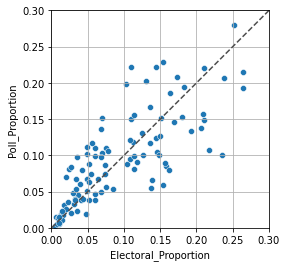

In [7]:
plt2 = sns.scatterplot(dfdemographic.Electoral_Proportion,dfdemographic.Poll_Proportion)
plt2.grid(True)
plt2.set(xlim = [0, 0.3])
plt2.set(ylim = [0, 0.3])
plt2.set_aspect('equal')
plt.plot([0, 10], [0, 10], ls="--", c=".3")
plt.savefig('PartA-2.svg')

<font color='blue'>Which group is most over-represented? Most under-represented?</font>

In [8]:
dfdemographic['Representation'] = dfdemographic.Electoral_Proportion/dfdemographic.Poll_Proportion
dfdemographic.sort_values(by=['Representation'], ascending = False)

,Electoral_Proportion,Poll_Proportion,Demographic_Type_1,Demographic_Type_2,Demographic_1,Demographic_2,Representation
102,0.153247,0.058824,age,education,65+,High School,2.605195
49,0.137253,0.055363,party,education,Republican,High School,2.479136
96,0.048088,0.019608,age,education,30-44,High School,2.452499
105,0.235884,0.100346,race,education,White,High School,2.350702
99,0.139230,0.065744,age,education,45-64,High School,2.117763
...,...,...,...,...,...,...,...
80,0.006011,0.014994,age,race,18-29,Other,0.400894
30,0.034919,0.098039,party,age,Independent,18-29,0.356171
113,0.027588,0.084198,race,education,Hispanic,College,0.327657
95,0.023934,0.080738,age,education,18-29,College,0.296438


We can see that the 65+ aged high school educated demographic was most underrepresented, with 2.6 times higher electoral estimates than polling numbers.
The 18-29 aged Hispanic demographic was most overrepresented, with 0.29 times lower electoral estimates than polling results.

## Part B: Weighting

### 1) Raw average

<font color='blue'> For now, we'll ignore people who answered anything but "Hillary Clinton" or "Donald Trump." Below, report the "raw polling average," the percentage of people "Hillary Clinton" divided by the number who answered either Hillary or Trump.

In [9]:
poll_grouped = dfpoll.groupby('candidate')['candidate'].count().reset_index(name ='count')
main_candidates = poll_grouped[(poll_grouped.candidate.isin(['Donald Trump', 'Hillary Clinton']))]
main_candidates

,candidate,count
1,Donald Trump,327
2,Hillary Clinton,393


In [10]:
hillary_poll = main_candidates['count'].iloc[1]/main_candidates['count'].sum()
hillary_poll

0.5458333333333333

The raw polling average for Hillary Clinton is 0.54583

### 2) Single dimensional marginal weighting (on just 1 demographic type)

<font color='blue'> For each demographic type separately -- age, gender, party, race, and education -- weight the poll by just that demographic type, in accordance to the population proportions given. Report the resulting poll results, and briefly (at most 3 sentences) describe what you observe.

You'll notice that some of the groups in the polling data ("refused") do not show up in the population percentages. For now, we'll ignore those respondents.

Function that returns Hillary's weighted poll result out of the top two candidates for a selected demographic.

In [11]:
def weighted_hillary(demographic, indices):

    proportions = dfdemographic[['Demographic_1', 'Electoral_Proportion']].iloc[indices[0]:indices[1]]
    grouped = dfpoll.groupby(['candidate', demographic])[demographic].count().reset_index(name ='count')
    grouped['count_weighted'] = ""

    for i, r in grouped.iterrows():
        if grouped[demographic].iloc[i] == 'Refused':
            weight_factor = 0
        else:
            weight_factor = proportions[(proportions['Demographic_1'] ==
                                 grouped[demographic].iloc[i])]['Electoral_Proportion'].iloc[0]

        grouped['count_weighted'].iloc[i] = grouped['count'].iloc[i] * weight_factor

    w_sum = grouped[(grouped['candidate'].isin(['Hillary Clinton', 'Donald Trump']))]['count_weighted'].sum()
    w_result = grouped.groupby('candidate')['count_weighted'].sum().reset_index(name ='count')
    w_hillary = w_result[(w_result['candidate'] == 'Hillary Clinton')]['count'].iloc[0]

    return w_hillary/w_sum

In [12]:
search = {'age': [5,9],
        'gender': [3,5],
        'party': [0,3],
        'race': [9,13],
        'education': [13,16]}
one_d1_weighted = []

In [13]:
one_d1_weighted.append(weighted_hillary('age',search['age']))
one_d1_weighted[0]

C:\Users\marti\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.518554407848732

In [14]:
one_d1_weighted.append(weighted_hillary('gender',search['gender']))
one_d1_weighted[1]

0.5513711899050441

In [15]:
one_d1_weighted.append(weighted_hillary('party',search['party']))
one_d1_weighted[2]

0.5449174164088921

In [16]:
one_d1_weighted.append(weighted_hillary('race',search['race']))
one_d1_weighted[3]

0.4378478975967778

In [17]:
one_d1_weighted.append(weighted_hillary('education',search['education']))
one_d1_weighted[4]

0.5464682164873779

Compared to the raw polling average of 0.54583, gender, party, and education seem to be fairly well representative of the population.
However, we see discrepancies in age and race.
They both indicate that Hillary Clinton is slightly over-represented at polls by certain demographics in these demographic categories.

### 2-dimensional joint distribution weighting

<font color='blue'>Now, for each pair of demographic types in dfdemographic, do the same -- weight the poll by that pair of demographic types, in accordance to the given joint distributions, and briefly (at most 3 sentences) describe what you observe

In [18]:
dfdemographic['Weighted_Result'] = ""
dfdemographic['Hillary_Weighted'] = ""

for index, row in dfdemographic.iterrows():
    type_list = dfdemographic[['Demographic_Type_1', 'Demographic_Type_2']].iloc[index].values.tolist()
    type_list.insert(0,'candidate')
    group_list = dfdemographic[['Demographic_1', 'Demographic_2']].iloc[index].values.tolist()
    if pd.isna(type_list[1]) or pd.isna(type_list[2]):
        continue
    else:
        # print(type_list)
        df_group = dfpoll.groupby(type_list)[type_list[1]].count().reset_index(name ='count')

        if 'Refused' in df_group[(df_group[type_list[1]] == group_list[0]) &
                     (df_group[type_list[2]] == group_list[1])][type_list[1:2]].iloc[0]:
            weight_factor = 0
        else:
            weight_factor = dfdemographic['Electoral_Proportion'].iloc[index]

        # df_group['weighted_count'] = df_group['count'].iloc[index] * weight_factor
        dfdemographic['Weighted_Result'].iloc[index] = df_group[(df_group[type_list[1]] == group_list[0]) &
                     (df_group[type_list[2]] == group_list[1]) & (df_group['candidate'].isin(['Hillary Clinton','Donald Trump']))]['count'].sum() \
                                                       * weight_factor

        if (df_group[(df_group[type_list[1]] == group_list[0]) &
                     (df_group[type_list[2]] == group_list[1]) &
                     (df_group['candidate'] == 'Hillary Clinton')])['count'].empty:
            dfdemographic['Hillary_Weighted'].iloc[index] = 0
            # print(index)
            # print(row)
        else:
            dfdemographic['Hillary_Weighted'].iloc[index] = (df_group.loc[(df_group[type_list[1]] == group_list[0]) &
                     (df_group[type_list[2]] == group_list[1]) & (df_group['candidate'] == 'Hillary Clinton')])['count'].iloc[0] \
                                                            * weight_factor

Let's check that Hillary didn't get any votes for this demographic which we set to 0. It is indeed only Donald Trump.

In [19]:
group_test = dfpoll.groupby(['candidate','party','race'])['race'].count().reset_index(name ='count')
group_test.loc[(group_test['race'] == 'Other') &
                (group_test['party'] == 'Republican')]

,candidate,party,race,count
25,Donald Trump,Republican,Other,5


In [20]:
weighted_2d_grouped = dfdemographic.groupby(['Demographic_Type_1', 'Demographic_Type_2'])['Weighted_Result'].sum().reset_index(name ='sum')
weighted_2d_grouped['Hillary_sum'] = ""
weighted_2d_grouped['Hillary_sum'] = dfdemographic.groupby(['Demographic_Type_1', 'Demographic_Type_2'])['Hillary_Weighted'].sum().reset_index(name ='sum')['sum']
weighted_2d_grouped['Hillary_proportion'] = ""
weighted_2d_grouped['Hillary_proportion'] = weighted_2d_grouped['Hillary_sum']/weighted_2d_grouped['sum']
weighted_2d_grouped

,Demographic_Type_1,Demographic_Type_2,sum,Hillary_sum,Hillary_proportion
0,age,education,64.813978,33.788998,0.521323
1,age,race,102.951816,43.151167,0.419139
2,gender,age,99.658294,52.328942,0.525084
3,gender,education,117.313169,64.664553,0.551213
4,gender,race,172.696859,76.470081,0.442799
5,party,age,67.440461,34.705966,0.514616
6,party,education,77.922983,41.771368,0.536060
7,party,gender,121.598110,67.067441,0.551550
8,party,race,121.032888,46.543016,0.384549
9,race,education,114.629296,50.250286,0.438372


It is obvious to us from the above grouped table that Hillary's numbers were overrepresented at polling - I also tried doing it for Trump, and his numbers increased substantially.
Weighting by the pairs of demographic types yields quite a bit lower numbers - 5-10% lower than the raw polling result.
This tells us that the joint distributions, most significantly with party and race - had an over-representation in their demographic groups during polling for Hillary Clinton -
in fact, the party = republican and race = other demographic consisted of no Hillary responses.

### 3) 2-dimensional marginal 

<font color='blue'>We don't always have access to joint distributions across the population -- for example, it may be hard to estimate from past exit polls (surveys done as people are leaving the polling station) what the joint distribution of education and gender is, for example. However, access to marginal distributions are often available. 

As discussed in class, one strategy when you don't have access to joint distributions -- only marginals -- is to _multiply_ the marginal distributions. For example, if 50% of your population is Democratic and 50% is a woman, then pretend that 50% times 50% = 25% of your population is a Democratic women. Clearly this technique is not perfect, but it is sometimes a useful heuristic.   

For the following pairs of Demographic types, report the weighting results if you use the joint distributions in dfdemographic versus if you approximate the joint distribution using the marginals. Briefly (at most 3 sentences) describe what you observe.

(party, gender)

(race, gender)

In [21]:
dfdemographic["Marginal_Estimate"] = ""
dfdemographic["Marginal_Error"] = ""

for i, rows in dfdemographic.iterrows():
    if pd.isna(dfdemographic['Demographic_Type_2'].iloc[i]):
        continue
    else:
        d1 = dfdemographic['Demographic_1'].iloc[i]
        d2 = dfdemographic['Demographic_2'].iloc[i]
        estimate1 = dfdemographic[(dfdemographic['Demographic_1'] == d1) & (pd.isnull(dfdemographic['Demographic_2']))]['Electoral_Proportion'].iloc[0]
        estimate2 = dfdemographic[(dfdemographic['Demographic_1'] == d2) & (pd.isnull(dfdemographic['Demographic_2']))]['Electoral_Proportion'].iloc[0]
        product = estimate1 * estimate2
        dfdemographic["Marginal_Estimate"].iloc[i] = product
        error = abs(product-dfdemographic['Electoral_Proportion'].iloc[i])/dfdemographic['Electoral_Proportion'].iloc[i]
        dfdemographic["Marginal_Error"].iloc[i] = error

C:\Users\marti\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [22]:
dfdemographic['Marginal_Sum'] = ""
dfdemographic['Marginal_Hillary'] = ""

for index, row in dfdemographic.iterrows():
    type_list = dfdemographic[['Demographic_Type_1', 'Demographic_Type_2']].iloc[index].values.tolist()
    type_list.insert(0,'candidate')
    group_list = dfdemographic[['Demographic_1', 'Demographic_2']].iloc[index].values.tolist()
    if pd.isna(type_list[1]) or pd.isna(type_list[2]):
        continue
    else:
        # print(type_list)
        df_group = dfpoll.groupby(type_list)[type_list[1]].count().reset_index(name ='count')

        if 'Refused' in df_group[(df_group[type_list[1]] == group_list[0]) &
                     (df_group[type_list[2]] == group_list[1])][type_list[1:2]].iloc[0]:
            weight_factor = 0
        else:
            weight_factor = dfdemographic['Marginal_Estimate'].iloc[index]

        # df_group['weighted_count'] = df_group['count'].iloc[index] * weight_factor
        dfdemographic['Marginal_Sum'].iloc[index] = df_group[(df_group[type_list[1]] == group_list[0]) &
                     (df_group[type_list[2]] == group_list[1]) & (df_group['candidate'].isin(['Hillary Clinton','Donald Trump']))]['count'].sum() \
                                                       * weight_factor

        if (df_group[(df_group[type_list[1]] == group_list[0]) &
                     (df_group[type_list[2]] == group_list[1]) &
                     (df_group['candidate'] == 'Hillary Clinton')])['count'].empty:
            dfdemographic['Marginal_Hillary'].iloc[index] = 0
            # print(index)
            # print(row)
        else:
            dfdemographic['Marginal_Hillary'].iloc[index] = (df_group.loc[(df_group[type_list[1]] == group_list[0]) &
                     (df_group[type_list[2]] == group_list[1]) & (df_group['candidate'] == 'Hillary Clinton')])['count'].iloc[0] \
                                                            * weight_factor


In [23]:
weighted_marginal_grouped = dfdemographic.groupby(['Demographic_Type_1', 'Demographic_Type_2'])['Marginal_Sum'].sum().reset_index(name ='sum')
weighted_marginal_grouped['Marginal_Hillary'] = ""
weighted_marginal_grouped['Marginal_Hillary'] = dfdemographic.groupby(['Demographic_Type_1', 'Demographic_Type_2'])['Marginal_Hillary'].sum().reset_index(name ='sum')['sum']
weighted_marginal_grouped['M_Hillary'] = ""
weighted_marginal_grouped['M_Hillary'] = weighted_marginal_grouped['Marginal_Hillary']/weighted_marginal_grouped['sum']
weighted_marginal_grouped['Compare_given'] = weighted_2d_grouped['Hillary_proportion']
weighted_marginal_grouped.drop(['sum','Marginal_Hillary'], axis=1)


,Demographic_Type_1,Demographic_Type_2,M_Hillary,Compare_given
0,age,education,0.518844,0.521323
1,age,race,0.420640,0.419139
2,gender,age,0.525515,0.525084
3,gender,education,0.551905,0.551213
4,gender,race,0.444312,0.442799
5,party,age,0.520710,0.514616
6,party,education,0.544903,0.536060
7,party,gender,0.549290,0.551550
8,party,race,0.429003,0.384549
9,race,education,0.435564,0.438372


Party and gender are quite close - our marginal approximation is accurate, and the race and gender are even closer.
On the other hand, the approximation of party - race correlations is poor. This means that there are likely some external, higher order covariates or dynamics that
changes this demographic's response rate.

### 4) Bonus points (up to 6 points): Implement a "cheap" version of the MRP technique mentioned in class.

<font color='blue'> The above techniques use the mean answer among people who share a demographic as the estimate for that demographic. But that wastes information _across_ demographics. For example, maybe people who only have "Some College" are similar enough to people who have "High School" as to provide some useful information. 

First, do the following: use a logistic regression (or your favorite prediction tool) to predict candidate choice, using the demographics. You might want to convert some demographics (like education) to ordered numeric (e.g., 1, 2, 3) as opposed to using discrete categories. 

Here, you will earn partial bonus points by just reporting the predictions and comparing them to the means of each covariate group in the raw polling data. Give a scatter-plot, where each point is one combination of full demographics (age, gender, party, race/ethnicity, education), the X axis is the raw polling average for that combination, and the Y axis is your regression prediction for that combination.   

Then, once you have predictions for each set of covariates, "post-stratify" to get a single population estimate by plugging them into the above weighting techniques, where you use the predictions instead of the raw averages in that cell. Report the resulting estimates if you do the 2-dimensional joint weighting (on every pair).

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
df_log = pd.get_dummies(dfpoll)
# encoded = df_log.drop(['candidate_Do not know', 'candidate_Donald Trump', 'candidate_Someone else', 'candidate_Will not vote'], axis = 1)
X_train = df_log.drop(['candidate_Hillary Clinton'], axis=1)
Y_train = df_log['candidate_Hillary Clinton']

model = LogisticRegression()
model.fit(X_train, Y_train)

Y_predict = model.predict(X_train)
df_predicted = dfpoll.drop(['candidate'], axis = 1)
df_predicted['Hillary?'] = Y_predict
predicted_raw = df_predicted.groupby(['age', 'gender', 'party', 'race', 'education'])['Hillary?'].sum().reset_index(name ='predicted')['predicted']/df_predicted.groupby(['age', 'gender', 'party', 'race', 'education'])['Hillary?'].count().reset_index(name ='predicted')['predicted']
predicted_raw

0      0.000000
1      1.000000
2      1.000000
3      0.714286
4      0.333333
         ...   
230    0.000000
231    0.000000
232    0.000000
233    0.000000
234    0.000000
Name: predicted, Length: 235, dtype: float64

In [26]:
encoded = pd.get_dummies(dfpoll, columns=['candidate'])
encoded = encoded.drop(['candidate_Do not know', 'candidate_Donald Trump', 'candidate_Someone else', 'candidate_Will not vote'], axis = 1)
poll_raw = encoded.groupby(['age', 'gender', 'party', 'race', 'education'])['candidate_Hillary Clinton'].sum().reset_index(name ='poll')['poll']/encoded.groupby(['age', 'gender', 'party', 'race', 'education'])['candidate_Hillary Clinton'].count().reset_index(name ='poll')['poll']
poll_raw

0      0.000000
1      1.000000
2      1.000000
3      0.714286
4      0.333333
         ...   
230    0.000000
231    0.000000
232    0.000000
233    0.000000
234    0.000000
Name: poll, Length: 235, dtype: float64

C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


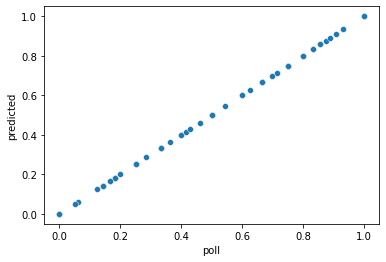

In [27]:
sns.scatterplot(poll_raw, predicted_raw);

It's basically a perfect prediction because the testing data is the training data. We see some slight jitter here and there but this is expected.

### 5) Bonus points (up to 3 points): Implement full "raking" using all the demographic covariates, i.e., match all the marginals without assuming independence, as opposed to just one or two marginal distributions.

<font color='blue'> You may use existing python packages, such as [here](https://quantipy.readthedocs.io/en/staging-develop/sites/lib_doc/weights/01_background.html#the-statistical-problem). Another approach would be to use [rpy2](https://rpy2.github.io/doc/latest/html/introduction.html) to call `R`, as there are many well-maintained packages in `R` to analyze polling data. One example is [here](https://www.rdocumentation.org/packages/survey/versions/4.1-1/topics/rake). 

## Part C: Uncertainty analysis and choices

### 1) Education weighting analysis and "refused" answers

<font color='blue'> i. In Part B, you should notice a discrepancy from what we said in class and the data -- weighting by education does _not_ seem to help much in reducing the polling average from being pro-Clinton. Dig into the data to see why the methods we tried above might not be perfect, and what data you would want (such as demographic joint distribution) to do better. Discuss in 5 sentences or less. Especially convincing would be plots/calculations on what would happen under hypothetical data. 

Hint: Look at polling average broken up by just education, and then broken up by education and other covariates. Especially helpful may be the following pandas command:

`dfpoll.groupby(['education', ...])['candidate'].value_counts(normalize = True)`

where ... is replaced by other columns

In [28]:
dfpoll.groupby(['education'])['candidate'].value_counts(normalize = True).reset_index(name ='proportion')

,education,candidate,proportion
0,College,Hillary Clinton,0.460317
1,College,Donald Trump,0.373016
2,College,Do not know,0.071429
3,College,Will not vote,0.060847
4,College,Someone else,0.034392
5,High School,Hillary Clinton,0.456140
6,High School,Donald Trump,0.397661
7,High School,Do not know,0.105263
8,High School,Will not vote,0.023392
9,High School,Someone else,0.017544


In [29]:
race_edu_cov = dfpoll.groupby(['education', 'race'])['candidate'].value_counts(normalize = True).reset_index(name ='proportion')
gender_edu_cov = dfpoll.groupby(['education', 'gender'])['candidate'].value_counts(normalize = True).reset_index(name ='proportion')
party_edu_cov = dfpoll.groupby(['education', 'party'])['candidate'].value_counts(normalize = True).reset_index(name ='proportion')
age_edu_cov = dfpoll.groupby(['education', 'age'])['candidate'].value_counts(normalize = True).reset_index(name ='proportion')

C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


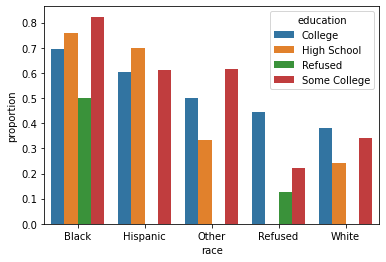

In [30]:
sns.barplot(race_edu_cov[race_edu_cov['candidate'] == 'Hillary Clinton']['race'],
            race_edu_cov[race_edu_cov['candidate'] == 'Hillary Clinton']['proportion'],
            hue = race_edu_cov['education']);


C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


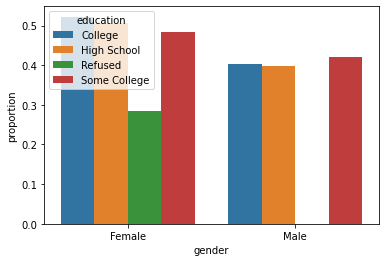

In [31]:
sns.barplot(gender_edu_cov[gender_edu_cov['candidate'] == 'Hillary Clinton']['gender'],
            gender_edu_cov[gender_edu_cov['candidate'] == 'Hillary Clinton']['proportion'],
            hue = gender_edu_cov['education']);

C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


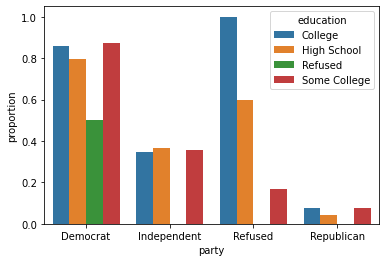

In [32]:
sns.barplot(party_edu_cov[party_edu_cov['candidate'] == 'Hillary Clinton']['party'],
            party_edu_cov[party_edu_cov['candidate'] == 'Hillary Clinton']['proportion'],
            hue = party_edu_cov['education']);

C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


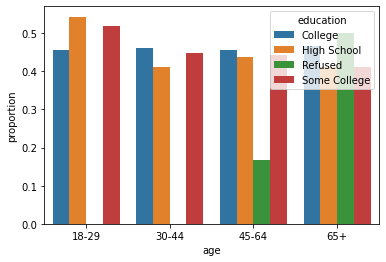

In [33]:
sns.barplot(age_edu_cov[age_edu_cov['candidate'] == 'Hillary Clinton']['age'],
            age_edu_cov[age_edu_cov['candidate'] == 'Hillary Clinton']['proportion'],
            hue = age_edu_cov['education']);


In [34]:
dfpoll.groupby(['education','age'])['education'].count().reset_index(name ='count')

,education,age,count
0,College,18-29,70
1,College,30-44,89
2,College,45-64,114
3,College,65+,105
4,High School,18-29,46
5,High School,30-44,17
6,High School,45-64,57
7,High School,65+,51
8,Refused,30-44,4
9,Refused,45-64,6


We can see that there are strong covariates with the join distributions in relation to education representing the shifting bar height per colour.
For each education class, the covariate category shifts the poll results massively, meaning that education is a poor sole variable conditional.
Ideally, we want to perform weighting on a joint distribution that is not too broad - thus breaking the cardinal rule - or too specific, in which
sparse data could give us extremely irregular results.
We also want to weight a joint distribution that is strongly misrepresented at polling - thus, we can perform an effective adjustment.
A good selection could be age and education.

<font color='blue'> ii. You'll notice that there are many responses with "refused," and that those people in particular are Trump-leaning. The weighting techniques we used above would ignore these people. How would you adjust your procedures/estimates above to take them into account? Especially convincing would be plots/calculations on what would happen under hypothetical data. Answer in at most 3 sentences.

Instead of filtering out the "refused" responses by weighting them as 0 as I did earlier, we should create a weight dependent on which metric was refused because people will refuse metrics for different reasons.
(I filtered the data and found that people only refused party, race, or education).

In [35]:
dfpoll.groupby(['education','age'])['education'].count().reset_index(name ='count')

,education,age,count
0,College,18-29,70
1,College,30-44,89
2,College,45-64,114
3,College,65+,105
4,High School,18-29,46
5,High School,30-44,17
6,High School,45-64,57
7,High School,65+,51
8,Refused,30-44,4
9,Refused,45-64,6


In [36]:
dfpoll[dfpoll['party'] == 'Refused'].groupby(['candidate'])['candidate'].count().reset_index(name ='party_refused')

,candidate,party_refused
0,Do not know,7
1,Donald Trump,1
2,Hillary Clinton,8
3,Will not vote,2


In [37]:
dfpoll[dfpoll['race'] == 'Refused'].groupby(['candidate'])['candidate'].count().reset_index(name ='race_refused')

,candidate,race_refused
0,Do not know,7
1,Donald Trump,10
2,Hillary Clinton,7
3,Someone else,1
4,Will not vote,3


In [38]:
dfpoll[dfpoll['education'] == 'Refused'].groupby(['candidate'])['candidate'].count().reset_index(name ='edu_refused')

,candidate,edu_refused
0,Do not know,5
1,Donald Trump,3
2,Hillary Clinton,2
3,Someone else,1
4,Will not vote,1


We see that those that refused party have a much higher tendency to vote Hillary -
those that refused race have a high tendency to vote Trump, but also are quite unsure -
those that refused education are more likely are very unsure.
I can also postulate that people that write "refused" on a poll have a differential non-response rate -
thus, I would propose to increase the weighting of each "refused section" until the demographic type matches the demographic information we have.

<font color='blue'> None of the above techniques deal with selection biases/non-response on _un-measured_ covariates. Do you think that may be an important concern in this dataset? Why or why not? Respond in 3 or fewer sentences.

There is absolutely some concern for unobserved variables because of the complexity of national elections.
A number of variables, not necessarily related to demographics, could be critical and are not measured in this data set.
Things like where and when the survey was posted, or even the type of questions asked, could all influence differential response rates.

### 2) Final estimates

<font color='blue'> Throughout this homework, you made many estimates of the same quantity -- the fraction of people who will vote for Clinton in Florida. Below, plot a histogram of all your estimates.

In [39]:
series = pd.melt(weighted_marginal_grouped[['M_Hillary','Compare_given']])['value'].tolist()

In [40]:
series.extend(one_d1_weighted)

In [41]:
series.append(hillary_poll)
series

[0.5188439806182912,
 0.42063970842870785,
 0.525514772314327,
 0.5519046932616885,
 0.4443122877636387,
 0.5207096063610529,
 0.5449027920893634,
 0.5492896058862125,
 0.4290033722095565,
 0.4355644439145237,
 0.5213227060036337,
 0.41913944623294813,
 0.5250836641084956,
 0.5512130790515796,
 0.44279948617279574,
 0.5146163883971423,
 0.536059664685837,
 0.5515500294636898,
 0.38454850400471596,
 0.43837210597362736,
 0.518554407848732,
 0.5513711899050441,
 0.5449174164088921,
 0.4378478975967778,
 0.5464682164873779,
 0.5458333333333333]

<AxesSubplot:ylabel='Count'>

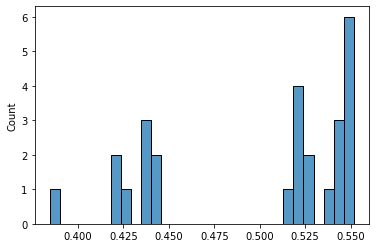

In [42]:
sns.histplot(series, bins = 30)

<font color='blue'> Given all your above analysis, if you were a pollster what would you report as your single estimate? 

I would use some average or weighted average of the joint weighted poll results.

In [43]:
weighted_marginal_grouped['Compare_given'].mean()

0.48847050740944653

<font color='blue'> Justify your choice, in at most 3 sentences

We know from our analysis that single variable weighting is quite insufficient and does not show the true story.
This seems like the most accurate method we have at the moment of weighting, thus there is no need to mix in other methods.
It's also extremely close to the actual Florida 2016 results of 49% Hillary proportion out of the top 2 candidates.

<font color='blue'> Though we did not discuss how to calculate margin of error or standard errors with weighting in this course, what would you say if someone asked you how confident you are in your estimate? You may either qualitatively answer, or try to come up with a margin of error.  

I don't think it's extremely accurate (certainly not to the nearest percent) because of how small the sample size was with less than 1000 pieces of data.
Out of about a 10,000,000 real world turnout, this is a very small number that can be drastically affected by "rogue covariates" that we can't account for such as regionality, seasonality, or the news.
The uncertainty would be more on the range of 2-3%.

In [44]:
import nbconvert
nbconvert

<module 'nbconvert' from 'C:\\Users\\marti\\anaconda3\\lib\\site-packages\\nbconvert\\__init__.py'>